In [74]:
import pandas as pd
import re

# Load data
data = pd.read_csv('code/results/res_20240313_145419/execution_times.csv')

# Remove rows with NaN values
data = data.dropna()

# Function to extract numeric part from time strings
def extract_time(s):
    m, s = re.match(r'(\d+)m(\d+\.\d+)s', s).groups()
    return int(m) * 60 + float(s)

# Apply the function to 'real', 'user', 'sys' columns and convert to float
for col in ['real', 'user', 'sys']:
    data[col] = data[col].apply(extract_time).astype(float)

# Extract the base filename
data['base_filename'] = data['filename'].str.extract(r'(.*?)(?=_\d+|$)')

# Group by base_filename and calculate mean, variance, and standard deviation
mean_result = data.groupby('base_filename')[['real', 'user', 'sys']].mean()
var_result = data.groupby('base_filename')[['real', 'user', 'sys']].var()
std_result = data.groupby('base_filename')[['real', 'user', 'sys']].std()

# Rename columns in variance and standard deviation results
var_result = var_result.rename(columns={"real": "real_var", "user": "user_var", "sys": "sys_var"})
std_result = std_result.rename(columns={"real": "real_std", "user": "user_std", "sys": "sys_std"})

# Join mean, variance, and standard deviation results
result = pd.concat([mean_result, var_result, std_result], axis=1)

display(result)

,real,user,sys,real_var,user_var,sys_var,real_std,user_std,sys_std
base_filename,,,,,,,,,
query1a_bigmv,18.5087,0.0398,0.0146,10.841249,0.000071,0.000064,3.292605,0.008443,0.008030
query1a_clean,24.0768,0.0419,0.0082,0.210992,0.000012,0.000017,0.459338,0.003510,0.004131
query1a_indexed,23.3487,0.0450,0.0130,0.153995,0.000054,0.000048,0.392422,0.007364,0.006944
query1a_mv,0.0919,0.0385,0.0072,0.000056,0.000040,0.000043,0.007460,0.006346,0.006563
query3a_bigmv,16.9969,0.0448,0.0100,0.517249,0.000042,0.000022,0.719200,0.006494,0.004738
query3a_clean,6.5519,0.0386,0.0096,0.031461,0.000014,0.000019,0.177371,0.003688,0.004326
query3a_indexed,0.0620,0.0404,0.0069,0.000310,0.000026,0.000021,0.017613,0.005082,0.004533
query3a_mv,0.0592,0.0415,0.0074,0.000064,0.000043,0.000024,0.007969,0.006519,0.004949


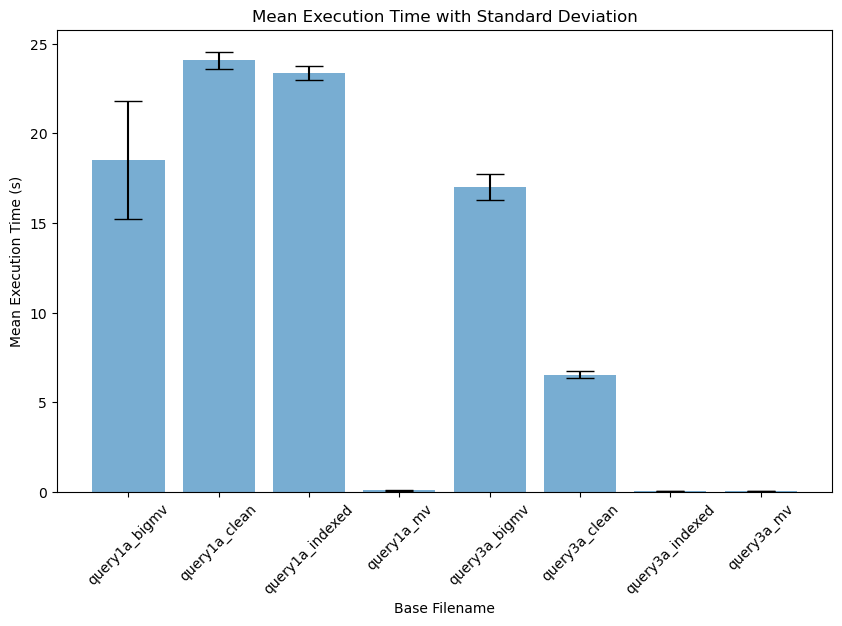

In [75]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a bar plot for 'real' column with 'real_std' as error bars
plt.bar(result.index, result['real'], yerr=result['real_std'], alpha=0.6, capsize=10)

# Set plot title and labels
plt.title('Mean Execution Time with Standard Deviation')
plt.xlabel('Base Filename')
plt.ylabel('Mean Execution Time (s)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

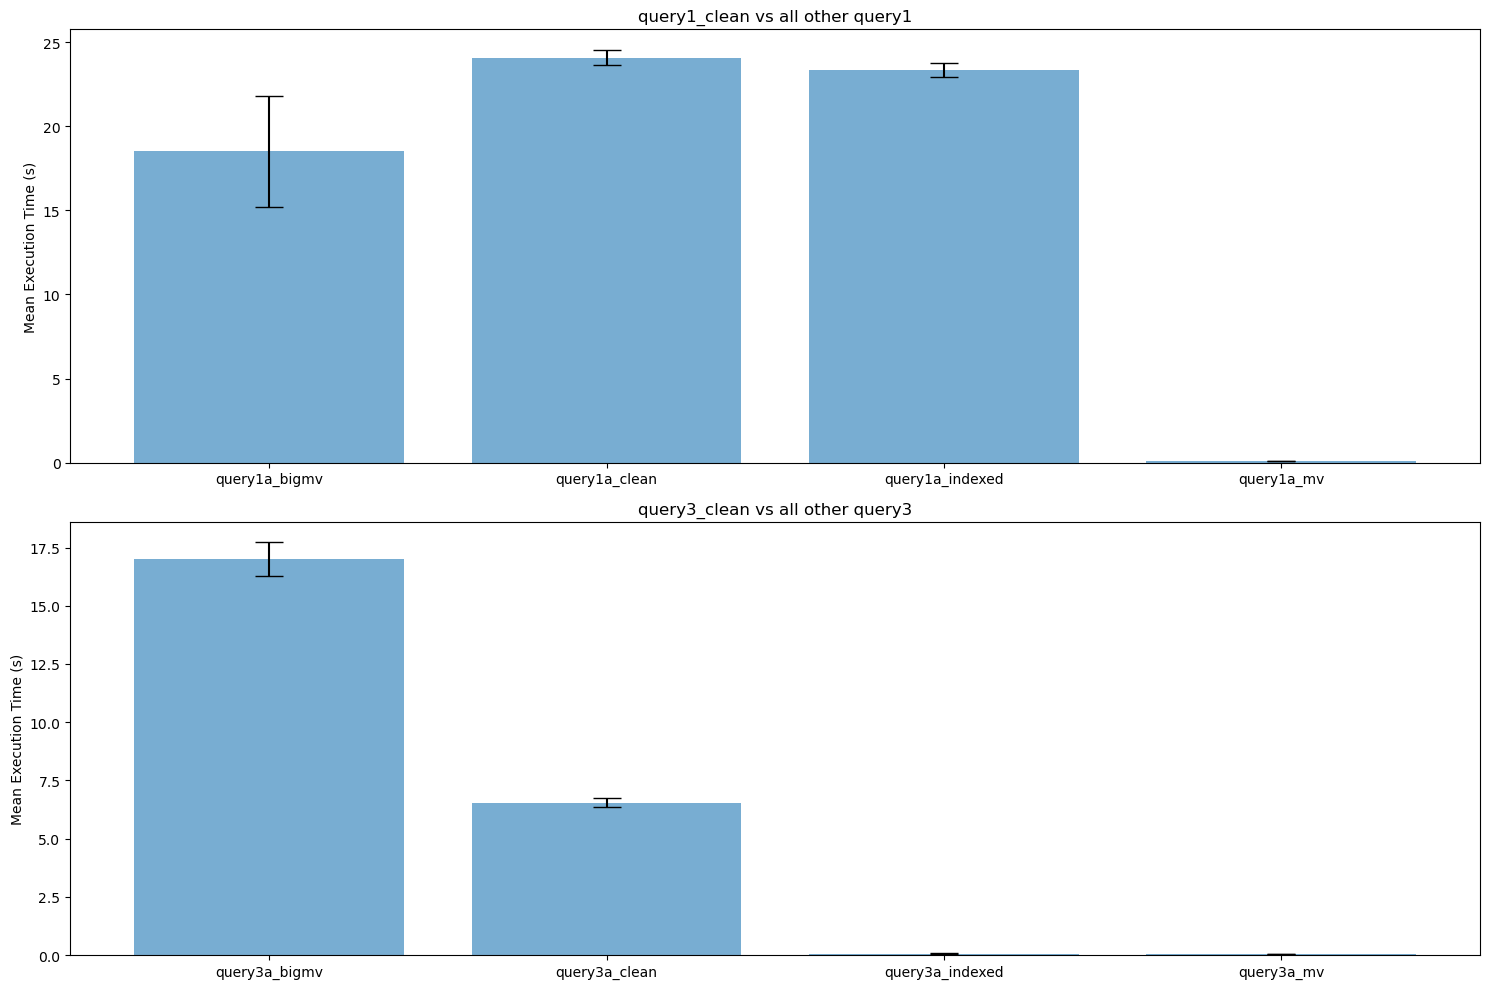

In [76]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# query1_clean with all other query1
query1 = [q for q in result.index if 'query1' in q]
axs[0].bar(result.loc[query1].index, result.loc[query1]['real'], 
           yerr=result.loc[query1]['real_std'], alpha=0.6, capsize=10)
axs[0].set_title('query1_clean vs all other query1')

# query3_clean with all other query3
query3 = [q for q in result.index if 'query3' in q]
axs[1].bar(result.loc[query3].index, result.loc[query3]['real'], 
           yerr=result.loc[query3]['real_std'], alpha=0.6, capsize=10)
axs[1].set_title('query3_clean vs all other query3')

for ax in axs.flat:
    ax.set(ylabel='Mean Execution Time (s)')

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
import os
import re
import pandas as pd

# Directory path
dir_path = './code/results/res_20240313_145419'

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['filename', 'table', 'number_of_rows', 'table_size_MB', 'index_size_MB'])

# Get a list of all text files
files = [f for f in os.listdir(dir_path) if f.startswith('stat_') and f.endswith('.txt')]

# Regular expression patterns
table_pattern = r'(\w+)\s+\*\*\* Statistics for Table:'
row_pattern = r'Number of rows:\s+(\d+)'
table_size_pattern = r'Table size:\s+(\d+)\s+(MB|kB)'
index_size_pattern = r'Index size:\s+(\d+)\s+(MB|kB)'

# Process each file
for file in files:
    with open(os.path.join(dir_path, file), 'r') as f:
        content = f.read()
        
        # Extract table names and statistics
        tables = re.findall(table_pattern, content)
        number_of_rows_list = [int(x) for x in re.findall(row_pattern, content)]
        table_sizes = [int(x[0]) if x[1] == 'MB' else int(x[0]) / 1024 for x in re.findall(table_size_pattern, content)]
        index_sizes = [int(x[0]) if x[1] == 'MB' else int(x[0]) / 1024 for x in re.findall(index_size_pattern, content)]
        
        # Append to DataFrame
        for table, number_of_rows, table_size, index_size in zip(tables, number_of_rows_list, table_sizes, index_sizes):
            df.loc[len(df)] = [file, table, number_of_rows, table_size, index_size]

df

,filename,table,number_of_rows,table_size_MB,index_size_MB
0,stat_idx1_20240313_145419.txt,lineitem,59986052,2481.000000,2457.000000
1,stat_idx1_20240313_145419.txt,orders,15000000,377.000000,442.000000
2,stat_idx1_20240313_145419.txt,part,2000000,20.000000,57.000000
3,stat_idx1_20240313_145419.txt,supplier,100000,0.023438,2.843750
4,stat_idx1_20240313_145419.txt,nation,25,0.023438,0.015625
5,stat_idx1_20240313_145419.txt,region,5,370.000000,0.015625
6,stat_idx3_20240313_145419.txt,lineitem,59986052,2481.000000,2027.000000
7,stat_idx3_20240313_145419.txt,orders,15000000,363.000000,442.000000
8,stat_idx3_20240313_145419.txt,part,2000000,20.000000,43.000000
9,stat_idx3_20240313_145419.txt,supplier,100000,0.023438,2.156250
